# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlwt 
from xlwt import Workbook 
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

print('Libraries Loaded')

Libraries Loaded


# Utilities

In [77]:
def read_file(path):
    '''
    Returns the dataframe which is read from the excel file present in the path specified. 
    
    Parameters:
        path (str) : The path of the file
    
    Returns:
        df (float) : The dataframe which is created after reading the file.
    '''
    df= pd.read_excel(path)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(df.shape)
    print(df.head())
    return df

def create_dataset(X, y, time_steps, ts_range):
    '''
    Returns the prepared data based on the lag and look ahead
    
    Parameters:
        X          (float): The independent variables of the data
        y          (float): The dependent variables of the data
        time_steps (int)  : The lag that is being used to lookback
        ts_range   (int)  : The lookahead for the data
    
    Returns:
        Xs (float) : The numpy array of the input variable
        ys (float) : The numpy array of the output variable 
    '''
    Xs, ys = [], []
    for i in range(len(X) - time_steps - ts_range):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.values[(i + time_steps):(i + time_steps + ts_range),0])
    return np.array(Xs), np.array(ys)

def splitter(df,output,lag,duration,ts):
    '''
    Returns the training and testing data
    
    Parameters:
        df (float): The whole dataframe containing the independent and dependent variables
        output(str): The output variable 
        lag (int): The lag that needs to be applied for the data
        duration (int): The duration that is being considered as output
        ts (float): The percentage of training data
    
    Returns:
        x_train (float): The training data of independent variable 
        x_test (float): The testing data of independent variable
        y_train (float): The training data of the depenedent variable 
        y_test (float): The testing data of the dependent variable 
    '''
    assert (0. <= ts <= 1.)
    train_size = int(len(df) * ts)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df[train_size:]
    print(train.shape, test.shape)
    scaler,scaler_single = MinMaxScaler(feature_range=(0, 1)),MinMaxScaler(feature_range=(0, 1))

    scaler.fit(train)
    scaler_single.fit(train[output])

    train_scaled = pd.DataFrame(scaler.transform(train), columns=[df.columns])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=[df.columns])

    df_train = train_scaled.copy(deep=True)
    df_test = test_scaled.copy(deep=True)

    x_train,y_train = create_dataset(df_train,df_train[[output]],lag,duration)
    x_test, y_test = create_dataset(df_test, df_test[[output]], lag, duration)

    return x_train,x_test,y_train,y_test,scaler_single

class attention(keras.layers.Layer):
    '''
    Attention layer for the neural networks.
    
    if return_sequences=True, it will give 3D vector and if false it will give 2D vector. It is same as LSTMs.

    https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
    the  following code is being inspired from the above link.
    '''

    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def get_config(self):
        cfg = super().get_config()
        return cfg

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

def build_lstm(atten,inputs):
    '''
    Returns the LSTM model
    
    Parameters:
        atten (bool): Indicate whether attention layer is required or not. 
        inputs (ndarry): The numpy array highlighting the shape of the input
        
    Returns:
        model (obj): The model is being returned based on the parameters specified
    '''
    K.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(keras.layers.LSTM(64, return_sequences=True))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.LSTM(64, return_sequences=True))
    model.add(keras.layers.LSTM(64, return_sequences=True))
    if atten:
        model.add(attention(return_sequences=True))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(32))
    model.add(keras.layers.Dense(6))

    return model

def build_cnnlstm(atten,inputs):
    '''
    Returns the CNN-LSTM model
    
    Parameters:
        atten (bool): Indicate whether attention layer is required or not. 
        inputs (ndarry): The numpy array highlighting the shape of the input
        
    Returns:
        model (obj): The model is being returned based on the parameters specified
    '''
    K.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.Conv1D(64, kernel_size=3, input_shape=(inputs.shape[1],inputs.shape[2])))
    model.add(keras.layers.Conv1D(64, kernel_size=3))
    model.add(keras.layers.LSTM(64, return_sequences=True))
    model.add(keras.layers.LSTM(64, return_sequences=True))
    if atten:
        model.add(attention(return_sequences=True))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32))
    model.add(keras.layers.Dense(6))

    return model

def build_convlstm(atten,inputs):
    '''
    Returns the ConvLSTM model
    
    Parameters:
        atten (bool): Indicate whether attention layer is required or not. 
        inputs (ndarry): The numpy array highlighting the shape of the input
        
    Returns:
        model (obj): The model is being returned based on the parameters specified
    '''
    K.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True, 
                                      input_shape=(inputs.shape[1], inputs.shape[2], 
                                                   inputs.shape[3], inputs.shape[4])))
    model.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
    model.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
    model.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,2),return_sequences=True))
    if atten:
        model.add(attention(return_sequences=True))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32))
    model.add(keras.layers.Dense(6))

    return model

def build_seq2seq(atten,inputs):
    '''
    Returns the Seq2Seq model
    
    Parameters:
        atten (bool): Indicate whether attention layer is required or not. 
        inputs (ndarry): The numpy array highlighting the shape of the input
        
    Returns:
        model (obj): The model is being returned based on the parameters specified
    '''
    if atten: 
        K.clear_session()
        input_train = keras.layers.Input(shape=(inputs[1], inputs[2]))
        output_train = keras.layers.Input(shape=(inputs[4], inputs[5]))
        ###----------------------------------------Encoder Section------------------------------------------###
        encoder_first = keras.layers.LSTM(128, return_sequences=True, return_state=False)(input_train)
        encoder_second = keras.layers.LSTM(128, return_sequences=True)(encoder_first)
        encoder_third = keras.layers.LSTM(128, return_sequences=True)(encoder_second)
        encoder_fourth, encoder_fourth_s1, encoder_fourth_s2 = keras.layers.LSTM(128,return_sequences=True,return_state=True)(encoder_third)

        ###-----------------------------------------Decoder Section------------------------------------------###
        decoder_first = keras.layers.RepeatVector(output_train.shape[1])(encoder_fourth_s1)
        decoder_second = keras.layers.LSTM(128, return_state=False, return_sequences=True)(decoder_first, initial_state=[encoder_fourth_s1, encoder_fourth_s2])

        attention = keras.layers.dot([decoder_second, encoder_fourth], axes=[2, 2])
        attention = keras.layers.Activation('softmax')(attention)
        context = keras.layers.dot([attention, encoder_fourth], axes=[2, 1])

        decoder_third = keras.layers.concatenate([context, decoder_second])

        decoder_fourth = keras.layers.LSTM(128, return_sequences=True)(decoder_third)
        decoder_fifth = keras.layers.LSTM(128, return_sequences=True)(decoder_fourth)
        decoder_sixth = keras.layers.LSTM(128, return_sequences=True)(decoder_fifth)

        ###-----------------------------------------Output Section-----------------------------------------###
        output = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder_sixth)

        atten_seq = keras.Model(inputs=input_train, outputs=output)

        return atten_seq
    else:

        K.clear_session()
        input_train = keras.layers.Input(shape=(inputs[1], inputs[2]))
        output_train = keras.layers.Input(shape=(inputs[4], inputs[5]))

        ### --------------------------------Encoder Section -------------------------------------------###
        encoder_first = keras.layers.LSTM(128, return_sequences=True, return_state=False)(input_train)
        encoder_second = keras.layers.LSTM(128, return_sequences=True)(encoder_first)
        encoder_third = keras.layers.LSTM(128, return_sequences=True)(encoder_second)
        encoder_fourth, encoder_fourth_s1, encoder_fourth_s2 = keras.layers.LSTM(128,return_sequences=False, return_state=True)(encoder_third)

        ###---------------------------------Decorder Section-----------------------------------------------###
        decoder_first = keras.layers.RepeatVector(output_train.shape[1])(encoder_fourth)
        decoder_second = keras.layers.LSTM(128, return_state=False, return_sequences=True)(decoder_first,initial_state=[encoder_fourth,encoder_fourth_s2])
        decoder_third = keras.layers.LSTM(128,return_sequences=True)(decoder_second)
        decoder_fourth = keras.layers.LSTM(128,return_sequences=True)(decoder_third)
        decoder_fifth = keras.layers.LSTM(128,return_sequences=True)(decoder_fourth)

        ###--------------------------------Output Section-------------------------------------------------###
        output = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder_fifth)

        simple_seq = keras.Model(inputs=input_train, outputs=output)

        return simple_seq
    
def build_wavenet(atten,inputs):
    '''
    Returns the WaveNet model
    
    Parameters:
        atten (bool): Indicate whether attention layer is required or not. 
        inputs (ndarry): The numpy array highlighting the shape of the input
        
    Returns:
        model (obj): The model is being returned based on the parameters specified
    '''
    n_filters = 128
    filter_width = 2
    dilation_rates = [2**i for i in range(7)]

    inputs = keras.layers.Input(shape=(inputs.shape[1],inputs.shape[2]))
    x=inputs

    skips = []
    for dilation_rate in dilation_rates:

        x   = keras.layers.Conv1D(64, 1, padding='same')(x) 
        x_f = keras.layers.Conv1D(filters=n_filters,kernel_size=filter_width,padding='causal',dilation_rate=dilation_rate)(x)
        x_g = keras.layers.Conv1D(filters=n_filters,kernel_size=filter_width, padding='causal',dilation_rate=dilation_rate)(x)

        z = keras.layers.Multiply()([keras.layers.Activation('tanh')(x_f),keras.layers.Activation('sigmoid')(x_g)])

        z = keras.layers.Conv1D(64, 1, padding='same', activation='relu')(z)

        x = keras.layers.Add()([x, z])    

        skips.append(z)

    out = keras.layers.Activation('relu')(keras.layers.Add()(skips))
    if atten:
        out = attention(return_sequences=True)(out)
    out = keras.layers.Conv1D(128, 1, padding='same')(out)
    out = keras.layers.Activation('relu')(out)
    out = keras.layers.Dropout(0.4)(out)
    out = keras.layers.Conv1D(1, 1, padding='same')(out)

    out = keras.layers.Flatten()(out)
    out = keras.layers.Dense(6)(out)

    model = keras.Model(inputs, out)
    return model

    
        
def model_fit(dire,model,x_train,x_test,y_train,y_test,scaler,split,batch_size,epochs,chkpt,weights,types):
    '''
    The function acts as an utility to fit the model on the data specified. 
    
    Parameters:
        dire (str): Specifies the directory in which the files are supposed to be saved
        model (obj): The model which is supposed to fitted onto the data
        x_train (ndarry): The input training array
        x_test (ndarry): The input testing array
        y_train (ndarry): The output training array
        y_test (ndarry): The output testing array
        scaler (obj): The scaler that is being used to scale the values
        split (float): The validation split percentage
        batch_size (int): The batch size that is supposed to be used for the training
        epochs (int): The number of epochs for training
        chkpt (obj): The callback for saving for the optimum weights
        weights(str): The name of the optimum weights that are being saved
        types(str): The type of model used, i.e. Attention or Simple
        
    Returns:
        The function doesnt return anything, however, it saves the weight in the directory specified and also 
        saves the results in an excel file in the same directory.
    '''
    wk=Workbook()
    sheet1 = wk.add_sheet(types, cell_overwrite_ok=True)
    path_old = os.getcwd()
    try:
        os.chdir(os.path.join(dest,dire))
        print('Directory present')
    except FileNotFoundError:
        print('Creating a new directory......')
        os.chdir(os.path.join(dest))
        os.mkdir(dire)
        os.chdir(os.path.join(dest,dire))
        print('New Directory Created')

    history = model.fit(x_train,y_train,validation_split=split,batch_size=batch_size,epochs=epochs,callbacks=[chkpt])

    plt.plot(history.history['loss'],'r',label='Training Loss')
    plt.plot(history.history['val_loss'],'b',label='Validation Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    model.load_weights(weights)
    preds = model.predict(x_test)

    y_test_unscaled = scaler.inverse_transform(y_test)
    if dire=='Seq2Seq':
        preds = preds[:,:,0]
    y_pred_unscaled = scaler.inverse_transform(preds)

    e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
    print(f'The Mean Squared Error is: {e_mse}')

    for i in range(y_test.shape[1]):
            sheet1.write(0, 0, 'MSE')
            sheet1.write(0, 1, 'Hours Ahead')
            sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
            sheet1.write(i + 1, 1, i+1)
    wk.save(f'{types} Results.xls')
    
    os.chdir(path_old)
            
    return
        

# Data Preparation

In [3]:
## Specifying the source path
src = r'/Users/saad/Desktop/pavement/Data'
filename = r'Pave_data_cleaned.xlsx'

## Specifying the destination path
dest = r'/Users/saad/Desktop/pavement/Results'

## Reading the file
df = read_file(os.path.join(src,filename))

(10896, 7)
   Year  Month  Day  Hour  Temp  Solar  Pavement
0  2009     11    1     1   8.4    0.0  9.333333
1  2009     11    1     2   8.3    0.0  8.933333
2  2009     11    1     3   7.9    0.0  8.700000
3  2009     11    1     4   7.6    0.0  8.533333
4  2009     11    1     5   6.9    0.0  8.533333


In [4]:
## Creating the training and testing data
x_train,x_test,y_train,y_test,scaler = splitter(df[['Temp','Pavement']],['Pavement'],6,6,0.8)
print(f'The shape of x_train is {x_train.shape} and x_test is {x_test.shape}')
print(f'The shape of y_train is {y_train.shape} and y_test is {y_test.shape}')

(8716, 2) (2180, 2)
The shape of x_train is (8704, 6, 2) and x_test is (2168, 6, 2)
The shape of y_train is (8704, 6) and y_test is (2168, 6)


# Models

## LSTM Model

In [5]:
## Creating the prelimaries 

filepath_simple = 'simple_lstm.hdf5'
filepath_attention = 'attention_lstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

In [21]:
## Simple LSTM
simple_lstm = build_lstm(False,x_train)
simple_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
simple_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 64)             17152     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
dropout (Dropout)            (None, 6, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

Directory present
Train on 7833 samples, validate on 871 samples
7833/7833 [==============================] - 7s 834us/sample - loss: 0.0152 - mean_absolute_error: 0.0858 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411


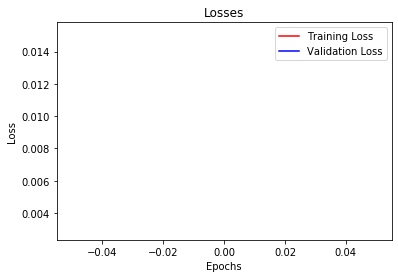

The Mean Squared Error is: 26.304148170183833


In [22]:
## Saving the result file to the folder of the model
model_fit('LSTM',simple_lstm,x_train,x_test,y_train,y_test,scaler,0.1,32,1,checkpoint_simple,filepath_simple,'Simple')

In [23]:
## Attention model
atten_lstm = build_lstm(True,x_train)
atten_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
atten_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 64)             17152     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
dropout (Dropout)            (None, 6, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
attention (attention)        (None, 6, 64)             70        
_________________________________________________________________
flatten (Flatten)            (None, 384)               0

Directory present
Train on 7833 samples, validate on 871 samples
7833/7833 [==============================] - 9s 1ms/sample - loss: 0.0166 - mean_absolute_error: 0.0916 - val_loss: 0.0025 - val_mean_absolute_error: 0.0396


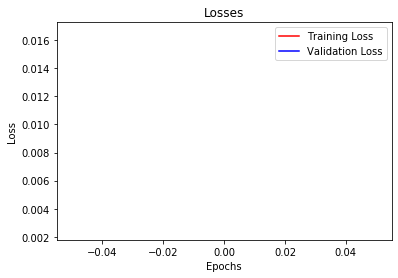

The Mean Squared Error is: 31.42140172431187


In [24]:
## Saving the result file to the folder of the model

model_fit('LSTM',atten_lstm,x_train,x_test,y_train,y_test,scaler,0.1,32,1,
          checkpoint_attention,filepath_attention,'Attention')

## CNN-LSTM

In [27]:
## Creating the prelimaries 

filepath_simple = 'simple_cnnlstm.hdf5'
filepath_attention = 'attention_cnnlstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

In [28]:
## Simple CNN-LSTM model
simple_cnnlstm = build_cnnlstm(False,x_train)
simple_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

Creating a new directory......
New Directory Created
Train on 7833 samples, validate on 871 samples
7833/7833 [==============================] - 3s 433us/sample - loss: 0.0330 - mean_absolute_error: 0.1229 - val_loss: 0.0032 - val_mean_absolute_error: 0.0472


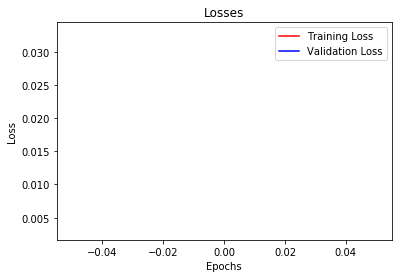

The Mean Squared Error is: 33.04004489915204


In [29]:
## Saving the result file to the folder of the model
model_fit('CNN-LSTM',simple_cnnlstm,x_train,x_test,y_train,y_test,scaler,0.1,32,1,
          checkpoint_simple,filepath_simple,'Simple')

In [30]:
## Attention model
atten_cnnlstm = build_cnnlstm(True,x_train)
atten_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

Directory present
Train on 7833 samples, validate on 871 samples
7833/7833 [==============================] - 3s 426us/sample - loss: 0.0386 - mean_absolute_error: 0.1348 - val_loss: 0.0033 - val_mean_absolute_error: 0.0476


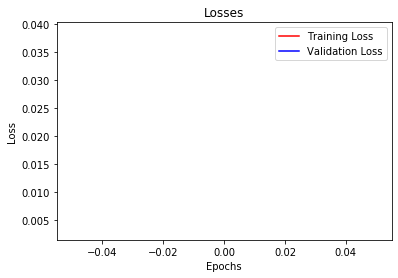

The Mean Squared Error is: 35.71867142819182


In [31]:
## Saving the result file to the folder of the model
model_fit('CNN-LSTM',atten_cnnlstm,x_train,x_test,y_train,y_test,scaler,0.1,32,1,
          checkpoint_attention,filepath_attention,'Attention')

## ConvLSTM Model

In [33]:
## Creating the prelimaries 

filepath_simple = 'simple_convlstm.hdf5'
filepath_attention = 'attention_convlstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

In [39]:
## Reshaping the training and testing data to suit the convlstm model
x_train_conv =x_train.reshape(x_train.shape[0], 1, 1, x_train.shape[1], x_train.shape[2])
x_test_conv = x_test.reshape(x_test.shape[0], 1, 1, x_test.shape[1], x_test.shape[2])

In [40]:
## Simple ConvLSTM model
simple_convlstm = build_convlstm(False,x_train_conv)
simple_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])
simple_convlstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 1, 5, 64)       34048     
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 1, 4, 64)       65792     
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 1, 3, 64)       65792     
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 1, 2, 64)       65792     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6

Directory present
Train on 7833 samples, validate on 871 samples
7833/7833 [==============================] - 6s 748us/sample - loss: 0.0474 - mean_absolute_error: 0.1618 - val_loss: 0.0078 - val_mean_absolute_error: 0.0709


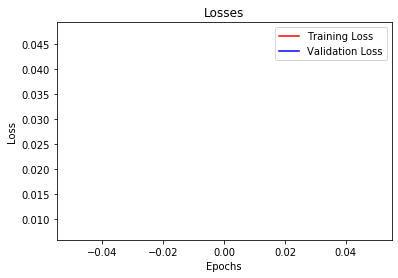

The Mean Squared Error is: 58.70609067873381


In [41]:
## Saving the result file to the folder of the model
model_fit('ConvLSTM',simple_convlstm,x_train_conv,x_test_conv,y_train,y_test,scaler,0.1,32,1,
          checkpoint_simple,filepath_simple,'Simple')

In [42]:
## Attention model
atten_convlstm = build_convlstm(True,x_train_conv)
atten_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])
atten_convlstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 1, 5, 64)       34048     
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 1, 4, 64)       65792     
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 1, 3, 64)       65792     
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 1, 1, 2, 64)       65792     
_________________________________________________________________
attention (attention)        (None, 1, 1, 2, 64)       65        
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               6

Directory present
Train on 7833 samples, validate on 871 samples
7833/7833 [==============================] - 6s 724us/sample - loss: 0.0555 - mean_absolute_error: 0.1789 - val_loss: 0.0078 - val_mean_absolute_error: 0.0699


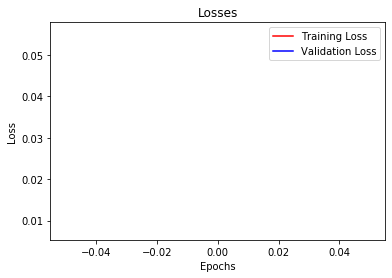

The Mean Squared Error is: 57.72982977044567


In [43]:
## Saving the result file to the folder of the model
model_fit('ConvLSTM',atten_convlstm,x_train_conv,x_test_conv,y_train,y_test,scaler,0.1,32,1,
          checkpoint_attention,filepath_attention,'Attention')

## Seq2Seq Model

In [44]:
## Creating the prelimaries 

filepath_simple = 'simple_seq2seq.hdf5'
filepath_attention = 'attention_seq2seq.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

In [52]:
## Reshaping the training data to suit Seq2Seq model
y_train_seq = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

## Combining the shapes of input and output

comb_shapes = [x_train.shape[0],x_train.shape[1],x_train.shape[2],y_train_seq.shape[0],y_train_seq.shape[1],y_train_seq.shape[2]]

In [65]:
## Simple Model

simple_seq = build_seq2seq(False,comb_shapes)
opt = keras.optimizers.Adam(learning_rate=0.001)
simple_seq.compile(loss='mse', optimizer=opt, metrics=['mae'])
simple_seq.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 2)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 6, 128)       67072       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 6, 128)       131584      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 6, 128)       131584      lstm_1[0][0]                     
______________________________________________________________________________________________

Directory present
Train on 7833 samples, validate on 871 samples
7833/7833 [==============================] - 15s 2ms/sample - loss: 0.0166 - mean_absolute_error: 0.0882 - val_loss: 0.0025 - val_mean_absolute_error: 0.0390


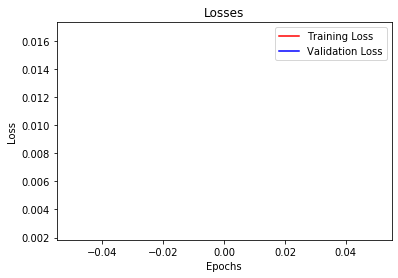

(2168, 6)
(2168, 6)
(2168, 6)
The Mean Squared Error is: 18.875276934323338


In [66]:
## Saving the result file to the folder of the model
model_fit('Seq2Seq',simple_seq,x_train,x_test,y_train_seq,y_test,scaler,0.1,32,1,
          checkpoint_simple,filepath_simple,'Simple')

In [68]:
## Attention Model
atten_seq = build_seq2seq(True,comb_shapes)
opt = keras.optimizers.Adam(learning_rate=0.0001)
atten_seq.compile(loss='mse', optimizer=opt, metrics=['mae'])
atten_seq.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 2)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 6, 128)       67072       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 6, 128)       131584      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 6, 128)       131584      lstm_1[0][0]                     
______________________________________________________________________________________________

Directory present
Train on 7833 samples, validate on 871 samples
7833/7833 [==============================] - 18s 2ms/sample - loss: 0.0476 - mean_absolute_error: 0.1687 - val_loss: 0.0051 - val_mean_absolute_error: 0.0599


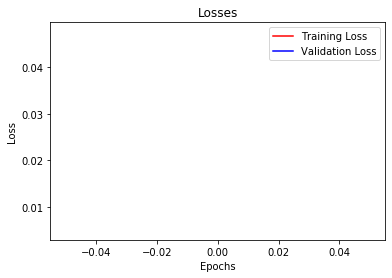

(2168, 6)
(2168, 6)
(2168, 6)
The Mean Squared Error is: 36.542214913387596


In [69]:
## Saving the result file to the folder of the model
model_fit('Seq2Seq',atten_seq,x_train,x_test,y_train_seq,y_test,scaler,0.1,32,1,
          checkpoint_attention,filepath_attention,'Attention')

## Wavenet Model

In [73]:
## Creating the prelimaries 

filepath_simple = 'simple_wavenet.hdf5'
filepath_attention = 'attention_wavenet.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

In [74]:
simple_wavenet = build_wavenet(False,x_train)
simple_wavenet.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

Creating a new directory......
New Directory Created
Train on 7833 samples, validate on 871 samples
7833/7833 [==============================] - 15s 2ms/sample - loss: 0.0199 - mean_absolute_error: 0.0979 - val_loss: 0.0018 - val_mean_absolute_error: 0.0330


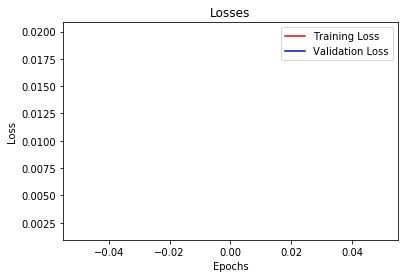

(2168, 6)
(2168, 6)
(2168, 6)
The Mean Squared Error is: 26.064189105670298


In [75]:
## Saving the result file to the folder of the model
model_fit('Wavenet',simple_wavenet,x_train,x_test,y_train,y_test,scaler,0.1,32,1,
          checkpoint_simple,filepath_simple,'Simple')

In [78]:
## Attention model
atten_wavenet = build_wavenet(True,x_train)
atten_wavenet.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])
atten_wavenet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6, 2)]       0                                            
__________________________________________________________________________________________________
conv1d_59 (Conv1D)              (None, 6, 64)        192         input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_60 (Conv1D)              (None, 6, 128)       16512       conv1d_59[0][0]                  
__________________________________________________________________________________________________
conv1d_61 (Conv1D)              (None, 6, 128)       16512       conv1d_59[0][0]                  
____________________________________________________________________________________________

Directory present
Train on 7833 samples, validate on 871 samples
7833/7833 [==============================] - 17s 2ms/sample - loss: 0.0185 - mean_absolute_error: 0.0936 - val_loss: 0.0026 - val_mean_absolute_error: 0.0412


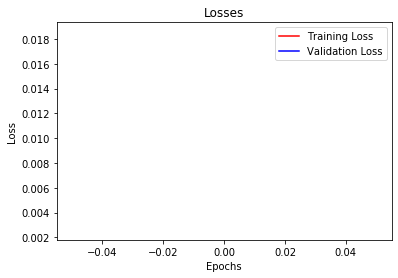

(2168, 6)
(2168, 6)
(2168, 6)
The Mean Squared Error is: 28.263661273452517


In [79]:
## Saving the result file to the folder of the model
model_fit('Wavenet',atten_wavenet,x_train,x_test,y_train,y_test,scaler,0.1,32,1,
          checkpoint_attention,filepath_attention,'Attention')